=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===

=== SCENARIO SUMMARY ===
                 soy_land_pc  total_land_pc   water_pc  protein_pc
scenario                                                          
40/60                 150.89         363.12  385148.20       22.00
40/60 + chicken       190.37         464.32  471648.20       26.60
50/50                 161.96         416.17  426611.14       22.00
Current               282.52         884.16  823303.98       28.71
Red meat cap          208.81         536.05  548212.21       22.00


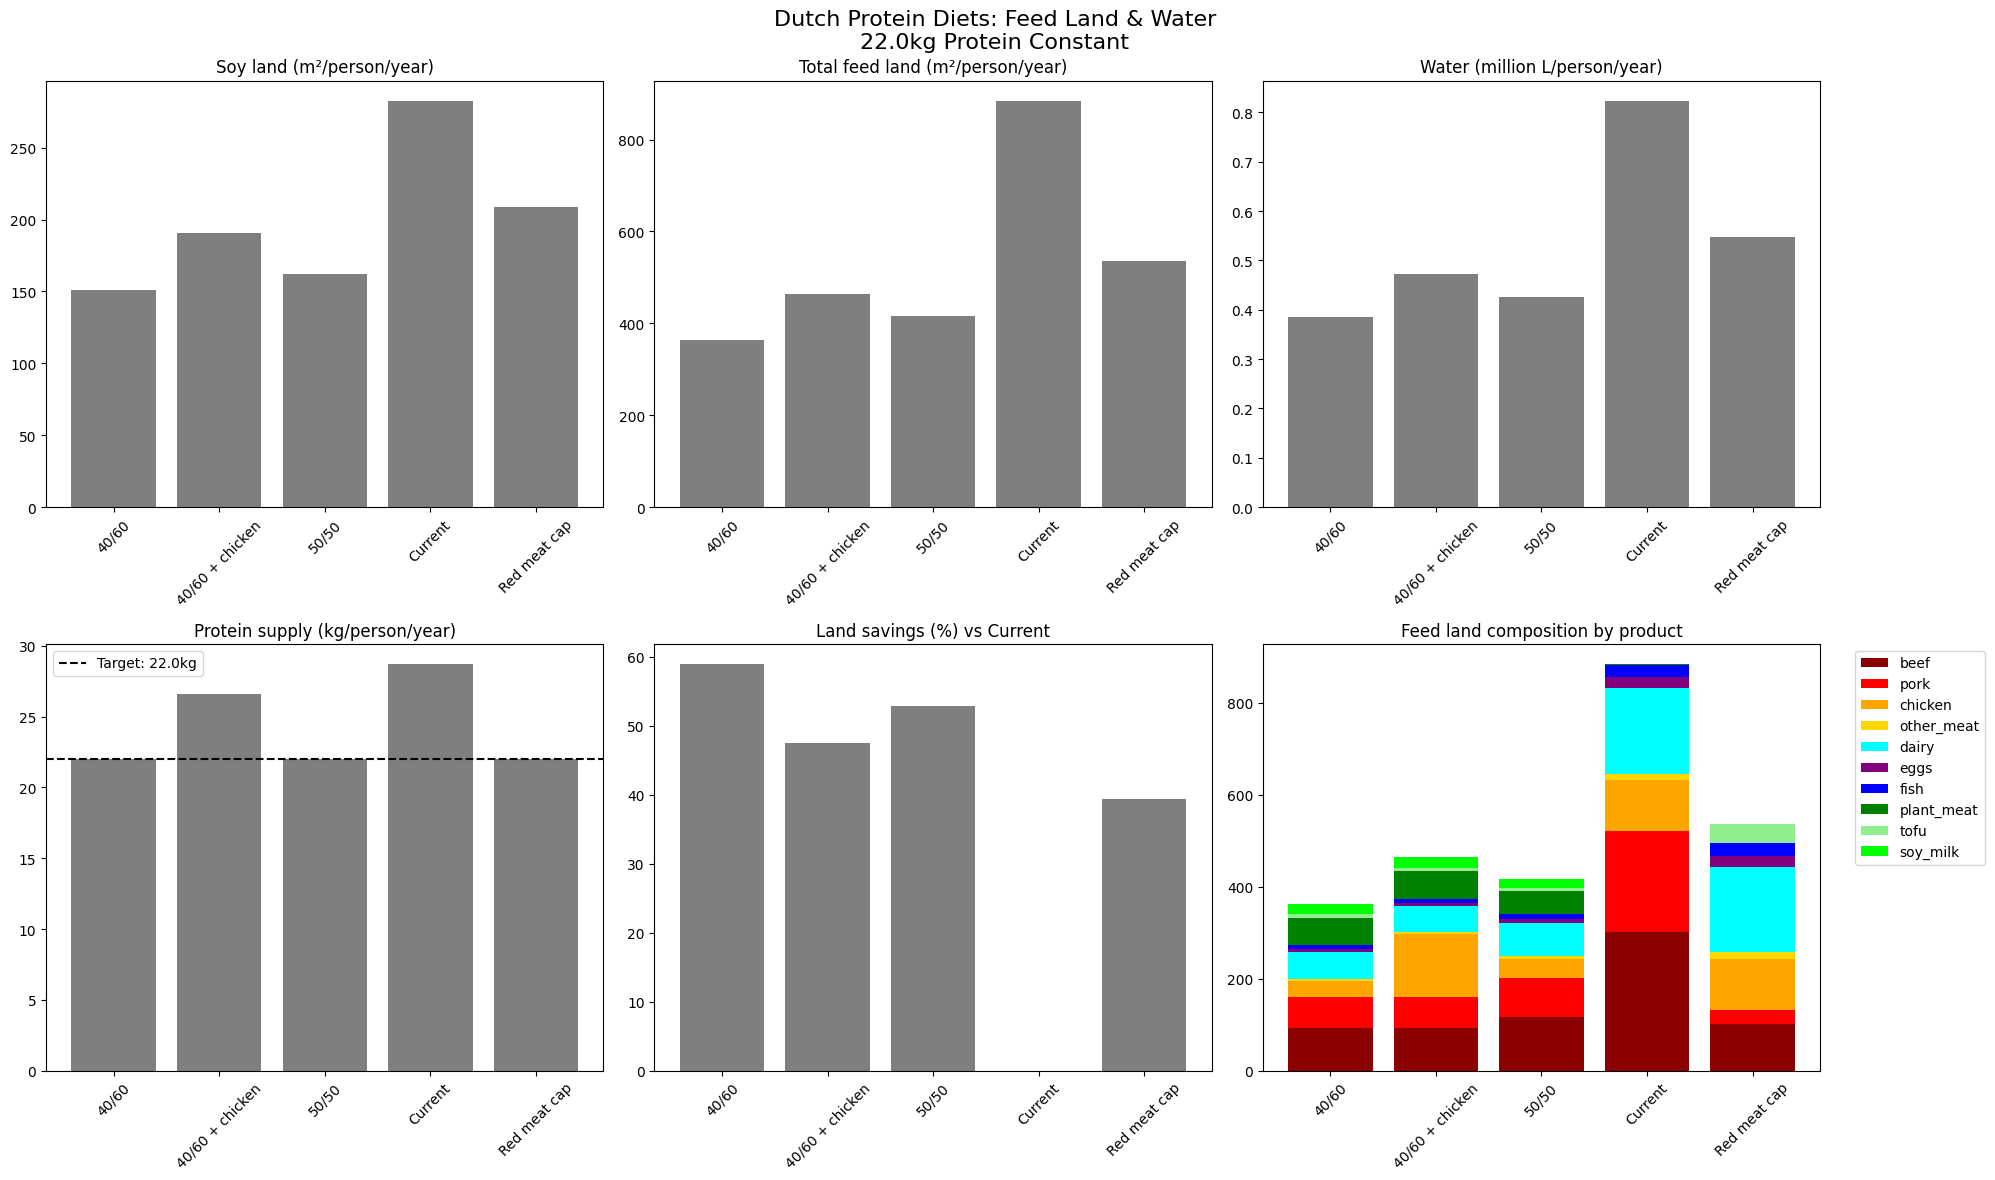

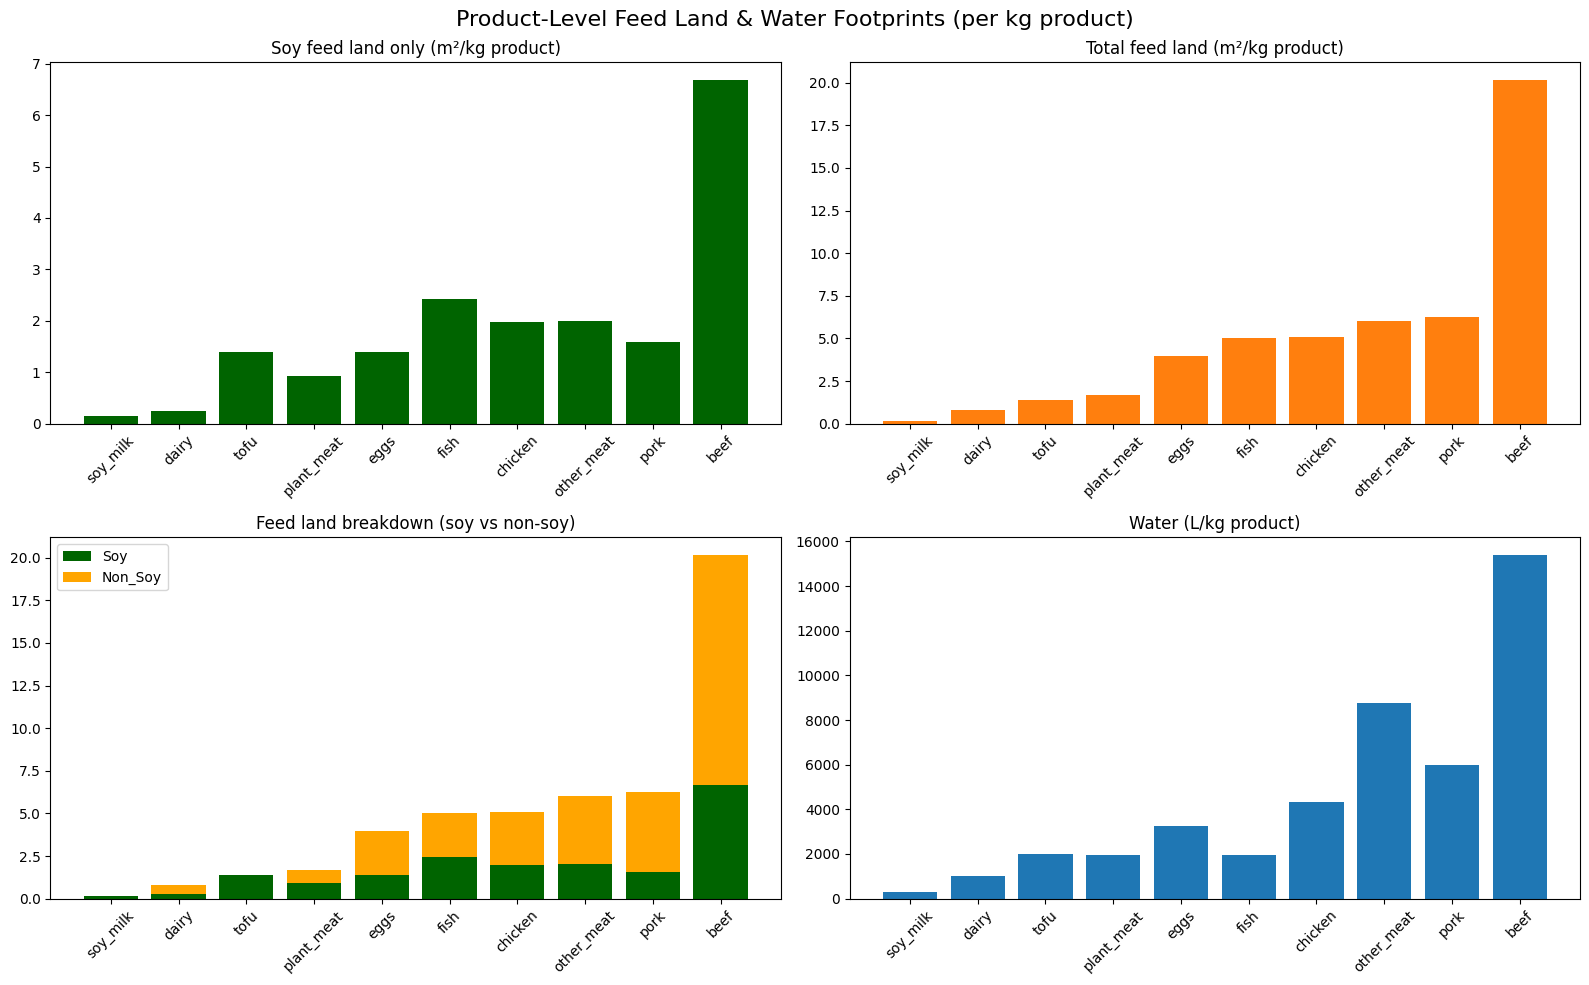

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== DUTCH PROTEIN DIETS: FOOD-FEED COMPETITION ===")

# ============================================
# 0. CONFIG
# ============================================
NL_POPULATION = 18_044_027  # 2025
PROTEIN_TARGET = 22.0  # kg protein/person/year

# Base product consumption (kg/person/year)
meat_2024_pc = {"pork": 35.1, "chicken": 22.0, "beef": 14.9, "other_meat": 2.4}
DAIRY_KG_PC = 230.7
EGGS_KG_PC = 5.840
FISH_KG_PC = 5.475
PLANT_MEAT_KG_PC = 10_200_000 / NL_POPULATION
TOFU_KG_PC = 1_630_000 / NL_POPULATION
SOY_MILK_KG_PC = 47_100_000 / NL_POPULATION

# Feed crop land (m²/kg)
CROP_LAND_M2_KG = {"maize":0.97, "wheat":1.18, "barley":1.53, "rapeseed":2.65, "soy":2.78}

# Feed shares per product
FEED_SHARES = {
    "dairy": {"maize":0.35, "soy":0.14, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.15, "other":0.03},
    "beef": {"maize":0.25, "soy":0.12, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.35, "other":0.02},
    "pork": {"maize":0.45, "soy":0.12, "wheat_barley":0.25, "rapeseed":0.08, "grass_hay":0.0, "other":0.10},
    "poultry": {"maize":0.55, "soy":0.20, "wheat_barley":0.15, "rapeseed":0.05, "grass_hay":0.0, "other":0.05},
    "eggs": {"maize":0.50, "soy":0.18, "wheat_barley":0.20, "rapeseed":0.06, "grass_hay":0.0, "other":0.06},
    "fish": {"maize":0.20, "soy":0.25, "wheat_barley":0.30, "rapeseed":0.05, "grass_hay":0.0, "other":0.20},
    "plant_meat": {"maize":0.15, "soy":0.33, "wheat_barley":0.40, "rapeseed":0.02, "grass_hay":0.0, "other":0.10},
    "plant_milk": {"maize":0.10, "soy":0.33, "wheat_barley":0.10, "rapeseed":0.02, "grass_hay":0.0, "other":0.45}
}

# ============================================
# 1. PRODUCTS DATAFRAME
# ============================================
products = [
    ("pork",4.74,230,"pork"),
    ("chicken",3.55,230,"poultry"),
    ("beef",20.06,340,"beef"),
    ("other_meat",6.00,200,"beef"),
    ("fish",3.50,230,"fish"),
    ("plant_meat",1.00,200,"plant_meat"),
    ("dairy",0.63,34,"dairy"),
    ("eggs",2.80,123,"eggs"),
    ("tofu",0.50,124,None),
    ("soy_milk",0.05,32,None)
]
df = pd.DataFrame(products, columns=["product","emcr","protein_g_kg","feed_type"])
df["soy_share"] = 0.0
df["soy_land"] = 0.0
df["non_soy_land"] = 0.0
df["total_land"] = 0.0
df["water_L_kg"] = [5988,4325,15415,8763,1974,1973,1020,3265,2000,297]

def compute_feed_land(emcr, feed_type):
    if feed_type is None:
        # Plant-only products
        soy_land = emcr * CROP_LAND_M2_KG["soy"]
        return 1.0, soy_land, 0.0
    shares = FEED_SHARES[feed_type]
    soy_share = shares["soy"]
    soy_land = emcr * soy_share * CROP_LAND_M2_KG["soy"]
    maize_kg = emcr * shares["maize"]
    wbar_kg = emcr * shares["wheat_barley"]
    rape_kg = emcr * shares["rapeseed"]
    non_soy_land = (maize_kg*CROP_LAND_M2_KG["maize"] + 
                    wbar_kg*(0.5*CROP_LAND_M2_KG["wheat"] + 0.5*CROP_LAND_M2_KG["barley"]) +
                    rape_kg*CROP_LAND_M2_KG["rapeseed"])
    return soy_share, soy_land, non_soy_land

for idx,row in df.iterrows():
    soy_share, soy_land, non_soy_land = compute_feed_land(row["emcr"], row["feed_type"])
    df.at[idx,"soy_share"]=soy_share
    df.at[idx,"soy_land"]=soy_land
    df.at[idx,"non_soy_land"]=non_soy_land
    df.at[idx,"total_land"]=soy_land+non_soy_land

# ============================================
# 2. HELPER FUNCTION TO ADD SCENARIO ROWS
# ============================================
def add(rows, scenario, prod, kg):
    sel = df.loc[df["product"]==prod]
    if sel.empty:
        raise ValueError(f"Product '{prod}' not found in df['product'].")
    r = sel.iloc[0]
    rows.append({
        "scenario": scenario,
        "product": prod,
        "kg_pc": kg,
        "protein_pc": kg * r.protein_g_kg / 1000,
        "soy_land_pc": kg * r.soy_land,
        "total_land_pc": kg * r.total_land,
        "water_pc": kg * r.water_L_kg
    })

# ============================================
# 3. SCENARIO BUILDER FUNCTIONS
# ============================================

def scale_to_protein(products_dict, target_protein):
    """Scale product kgs to hit target protein."""
    protein_per_kg = {p: df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in products_dict}
    total_protein_current = sum(products_dict[p]*protein_per_kg[p] for p in products_dict)
    factor = target_protein / total_protein_current
    return {p: products_dict[p]*factor for p in products_dict}

def build_scenarios():
    scenarios=[]
    
    # --- Current diet ---
    current_dict = {**meat_2024_pc, "dairy":DAIRY_KG_PC,"eggs":EGGS_KG_PC,"fish":FISH_KG_PC,
                    "plant_meat":PLANT_MEAT_KG_PC,"tofu":TOFU_KG_PC,"soy_milk":SOY_MILK_KG_PC}
    for prod,kg in current_dict.items():
        add(scenarios,"Current",prod,kg)
    
    # --- 40/60 ---
    animal_products = {k:current_dict[k] for k in ["pork","chicken","beef","other_meat","dairy","eggs","fish"]}
    plant_products = {k:current_dict[k] for k in ["plant_meat","tofu","soy_milk"]}
    animal_scaled = scale_to_protein(animal_products, PROTEIN_TARGET*0.4)
    plant_scaled = scale_to_protein(plant_products, PROTEIN_TARGET*0.6)
    for prod,kg in {**animal_scaled, **plant_scaled}.items():
        add(scenarios,"40/60",prod,kg)
    
    # --- 40/60 + chicken ---
    # Take 40/60 scenario and add extra chicken (e.g., double current chicken)
    for prod,kg in {**animal_scaled, **plant_scaled}.items():
        add(scenarios,"40/60 + chicken",prod,kg)
    extra_chicken = 20  # add 20kg protein-like units (can adjust)
    add(scenarios,"40/60 + chicken","chicken",extra_chicken)
    
    # --- 50/50 ---
    animal_scaled_5050 = scale_to_protein(animal_products, PROTEIN_TARGET*0.5)
    plant_scaled_5050 = scale_to_protein(plant_products, PROTEIN_TARGET*0.5)
    for prod,kg in {**animal_scaled_5050, **plant_scaled_5050}.items():
        add(scenarios,"50/50",prod,kg)
    
    # --- Red meat cap ---
    red_meat_cap = {"beef":5,"pork":5}
    rest_products = {k:current_dict[k] for k in current_dict if k not in red_meat_cap}
    # protein from capped red meat
    protein_from_red = sum(red_meat_cap[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in red_meat_cap)
    protein_rest = sum(rest_products[p]*df.loc[df["product"]==p,"protein_g_kg"].iloc[0]/1000 for p in rest_products)
    total_protein = protein_from_red + protein_rest
    # if <22kg, fill with tofu
    protein_gap = max(0, PROTEIN_TARGET - total_protein)
    for prod,kg in red_meat_cap.items():
        add(scenarios,"Red meat cap",prod,kg)
    for prod,kg in rest_products.items():
        add(scenarios,"Red meat cap",prod,kg)
    if protein_gap>0:
        prot_per_kg_tofu = df.loc[df["product"]=="tofu","protein_g_kg"].iloc[0]/1000
        add(scenarios,"Red meat cap","tofu",protein_gap/prot_per_kg_tofu)
    
    return pd.DataFrame(scenarios)

all_scenarios = build_scenarios()

# ============================================
# 4. SUMMARY TABLE
# ============================================
agg_pc = all_scenarios.groupby("scenario")[["soy_land_pc","total_land_pc","water_pc","protein_pc"]].sum()
print("\n=== SCENARIO SUMMARY ===")
print(agg_pc.round(2))

# ============================================
# 5. SCENARIO-LEVEL PLOTS - CLEAN REPORT STYLE
# ============================================
fig, axes = plt.subplots(2,3, figsize=(20,12))

# Use neutral gray color for all scenario bars
neutral_colors = ["#7f7f7f"]*len(agg_pc)

# Soy land
axes[0,0].bar(agg_pc.index, agg_pc["soy_land_pc"], color=neutral_colors)
axes[0,0].set_title("Soy land (m²/person/year)")
axes[0,0].tick_params(axis="x", rotation=45)

# Total land
axes[0,1].bar(agg_pc.index, agg_pc["total_land_pc"], color=neutral_colors)
axes[0,1].set_title("Total feed land (m²/person/year)")
axes[0,1].tick_params(axis="x", rotation=45)

# Water
axes[0,2].bar(agg_pc.index, agg_pc["water_pc"]/1e6, color=neutral_colors)
axes[0,2].set_title("Water (million L/person/year)")
axes[0,2].tick_params(axis="x", rotation=45)

# Protein supply
axes[1,0].bar(agg_pc.index, agg_pc["protein_pc"], color=neutral_colors)
axes[1,0].set_title("Protein supply (kg/person/year)")
axes[1,0].axhline(y=PROTEIN_TARGET, color="black", linestyle="--", label=f"Target: {PROTEIN_TARGET}kg")
axes[1,0].legend()
axes[1,0].tick_params(axis="x", rotation=45)

# Land savings
current_total = agg_pc.loc["Current","total_land_pc"]
land_savings = [(1 - v/current_total)*100 for v in agg_pc["total_land_pc"]]
axes[1,1].bar(agg_pc.index, land_savings, color=neutral_colors)
axes[1,1].set_title("Land savings (%) vs Current")
axes[1,1].tick_params(axis="x", rotation=45)

# Stacked land composition by product (keep original colors)
pivot = all_scenarios.pivot_table(index="scenario", columns="product", values="total_land_pc", aggfunc="sum", fill_value=0)
prod_colors = {
    "beef":"darkred","pork":"red","chicken":"orange","other_meat":"gold","dairy":"cyan",
    "eggs":"purple","fish":"blue","plant_meat":"green","tofu":"lightgreen","soy_milk":"lime"
}
bottom = np.zeros(len(agg_pc))
for prod in ["beef","pork","chicken","other_meat","dairy","eggs","fish","plant_meat","tofu","soy_milk"]:
    axes[1,2].bar(range(len(agg_pc)), pivot[prod], bottom=bottom, color=prod_colors[prod], label=prod)
    bottom += pivot[prod].values
axes[1,2].set_xticks(range(len(agg_pc)))
axes[1,2].set_xticklabels(agg_pc.index, rotation=45)
axes[1,2].set_title("Feed land composition by product")
axes[1,2].legend(bbox_to_anchor=(1.05,1), loc='upper left')

plt.suptitle(f"Dutch Protein Diets: Feed Land & Water\n{PROTEIN_TARGET}kg Protein Constant", fontsize=16)
plt.tight_layout()
plt.show()

# ============================================
# 6. PRODUCT-LEVEL FOOTPRINTS (2x2)
# ============================================
df_sorted = df.sort_values("total_land")
fig, axes = plt.subplots(2,2, figsize=(16,10))

axes[0,0].bar(df_sorted["product"], df_sorted["soy_land"], color="darkgreen")
axes[0,0].set_title("Soy feed land only (m²/kg product)")
axes[0,0].tick_params(axis="x", rotation=45)

axes[0,1].bar(df_sorted["product"], df_sorted["total_land"], color="tab:orange")
axes[0,1].set_title("Total feed land (m²/kg product)")
axes[0,1].tick_params(axis="x", rotation=45)

bottom = np.zeros(len(df_sorted))
for land_type,color in zip(["soy_land","non_soy_land"],["darkgreen","orange"]):
    axes[1,0].bar(df_sorted["product"], df_sorted[land_type], bottom=bottom, color=color, label=land_type.replace("_land","").title())
    bottom += df_sorted[land_type].values
axes[1,0].set_title("Feed land breakdown (soy vs non-soy)")
axes[1,0].legend()
axes[1,0].tick_params(axis="x", rotation=45)

axes[1,1].bar(df_sorted["product"], df_sorted["water_L_kg"], color="tab:blue")
axes[1,1].set_title("Water (L/kg product)")
axes[1,1].tick_params(axis="x", rotation=45)

plt.suptitle("Product-Level Feed Land & Water Footprints (per kg product)", fontsize=16)
plt.tight_layout()
plt.show()
